# Init

In [1]:
!pip install -qq shap
!pip install -qq lime
!pip install -qq xgboost
!pip install -qq scikit-multilearn
!pip install -qq pysastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 5.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import shap
import re
import random
import seaborn as sns
import warnings
import matplotlib
import string
warnings.filterwarnings("ignore", 'This pattern has match groups')
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
nltk.download('punkt')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
font = {'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
seed_val = 1906350912
random.seed(seed_val)
np.random.seed(seed_val)
categories = ['Anak', 'Bedah', 'Gigi', 'Gizi', 'Jantung', 'Jiwa',
       'Kandungan', 'Kulit dan Kelamin', 'Mata', 'Paru', 'Penyakit Dalam',
       'Saraf', 'THT', 'Tulang', 'Umum', 'Urologi']
# torch.manual_seed(seed_val)

In [4]:
df_train = pd.read_csv(f"Dataset/Human_Annotated.csv", index_col="ID")
df_train.fillna("", inplace = True)

df_train_umumnt = df_train.drop(columns=["Umum"])
df_train_umumnt["COUNT CLASS"] = df_train_umumnt.drop(columns=["JUDUL", "ISI"]).sum(axis=1)
df_train = df_train_umumnt[df_train_umumnt["COUNT CLASS"] > 0].drop(columns=["COUNT CLASS"])
del df_train_umumnt

df_train["ALL"] = df_train['JUDUL'] + " " + df_train['ISI']
df_train = df_train.drop(columns=['JUDUL', 'ISI'])
df_test = pd.read_csv(f"Dataset/Gold_standard.csv", index_col="ID")
df_test.fillna("", inplace = True)
df_test['Count'] = df_test.drop(columns=['JUDUL', 'ISI']).values.sum(axis=1)
df_test = df_test[df_test['Count'] <= 3].drop(columns=['Count'])
df_test = df_test[["JUDUL", "ISI"] + categories]

df_test_umumnt = df_test.drop(columns=["Umum"])
df_test_umumnt["COUNT CLASS"] = df_test_umumnt.drop(columns=["JUDUL", "ISI"]).sum(axis=1)
df_test = df_test_umumnt[df_test_umumnt["COUNT CLASS"] > 0].drop(columns=["COUNT CLASS"])
del df_test_umumnt

df_test["ALL"] = df_test['JUDUL'] + " " + df_test['ISI']
df_test = df_test.drop(columns=['JUDUL', 'ISI'])

In [5]:
categories = [
    'Kulit dan Kelamin', 'Mata', 'Paru', 'Gigi', 'Urologi',
    'Kandungan', 'Gizi', 'Jantung', 'Bedah', 'Jiwa',
    'Penyakit Dalam',
    'THT',
    'Anak', 'Tulang', 'Saraf',
    ]

In [6]:
short_cat = ['SpKK', 'SpM', 'SpP', 'SKG', 'SpU',
             'SpOG', 'SpGK', 'SpJP', 'SpB', 'SpKJ',
             'SpPD',
             'SpTHT',
             'SpA', 'SpOT', 'SpN']

In [7]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from skmultilearn.problem_transform import ClassifierChain, BinaryRelevance
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

# Function

In [8]:
def create_binary_model(clf, category, X, y, **kwargs):
  models = {}
  for i in range(len(category)):
    clfi = clf(**kwargs)
    clfi.fit(X,y[:,i])
    models[category[i]] = clfi
  return models

def create_chain_model(clf, category, X, y, **kwargs):
  res = {}
  new_X = X.copy()
  for i, col in enumerate(category):
    resi = {}
    resi["X"] = new_X
    clfi = clf(**kwargs)
    clfi.fit(new_X,y[:,i])
    resi["model"] = clfi
    y_pred = clfi.predict(new_X)
    res[col] = resi
    new_X = np.column_stack((new_X, y_pred))
  return res

In [9]:
def create_linear_explainer(clfs, category, X):
  explainers = {}
  for i in category:
    explaineri = shap.LinearExplainer(clfs[i], X)
    explainers[i] = explaineri
  return explainers

def create_linear_chain_explainer(chains):
  explainers = {}
  for col, chain in chains.items():
    explaineri = shap.LinearExplainer(chain["model"], chain["X"])
    explainers[col] = explaineri
  return explainers

def create_tree_explainer(clfs, category):
  explainers = {}
  for i in category:
    explaineri = shap.TreeExplainer(clfs[i])
    explainers[i] = explaineri
  return explainers

def create_kernel_explainer(clfs, category, X):
  explainers = {}
  for i in category:
    explaineri = shap.KernelExplainer(clfs[i].predict_proba, X)
    explainers[i] = explaineri
  return explainers

def create_explainer(clfs, category, X):
  explainers = {}
  for i in category:
    explaineri = shap.Explainer(clfs[i].predict, X)
    explainers[i] = explaineri
  return explainers

In [10]:
def summary_plots4(explainers, category, X1, tfidf):
  plt.figure(figsize = (20, 20))
  for i in range(len(category)):
    plt.subplot(4, 4, i+1)
    cat = category[i]
    plt.title(cat)
    shap.summary_plot(explainers[cat].shap_values(X1),
                      X1,
                      feature_names=tfidf.get_feature_names_out(),
                      plot_size=None,
                      max_display = 10,
                      show = False)
  # plt.tight_layout()
  plt.show()

def summary_chain_plots4(explainers, chain_test, tfidf_chain):
  plt.figure(figsize = (20, 20))
  for i, cat in enumerate(explainers.keys()):
    plt.subplot(4, 4, i+1)
    plt.title(cat)
    shap.summary_plot(explainers[cat].shap_values(chain_test[cat]),
                      chain_test[cat],
                      feature_names=tfidf_chain[cat],
                      plot_size=None,
                      max_display = 10,
                      show = False)
  # plt.tight_layout()
  plt.show()

def summary_plots(explainers, category, X1, tfidf):
  for i in range(len(category)):
    # plt.subplot(4, 4, i+1)
    cat = category[i]
    plt.title(cat)
    shap.summary_plot(explainers[cat].shap_values(X1),
                      X1,
                      feature_names=tfidf.get_feature_names_out(),
                      plot_size=None,
                      max_display = 10,
                      show = False)
    # plt.tight_layout()
    plt.show()

def summary_chain_plots(explainers, chain_test, tfidf_chain):
  for i, cat in enumerate(explainers.keys()):
    # plt.subplot(4, 4, i+1)
    plt.title(cat)
    shap.summary_plot(explainers[cat].shap_values(chain_test[cat]),
                      chain_test[cat],
                      feature_names=tfidf_chain[cat],
                      plot_size=None,
                      max_display = 10,
                      show = False)
    # plt.tight_layout()
    plt.show()

def save_chain_plots(explainers, chain_test, tfidf_chain):
  for i, cat in enumerate(explainers.keys()):
    plt.figure(figsize = (5, 5))
    plt.title(cat)
    shap.summary_plot(explainers[cat].shap_values(chain_test[cat]),
                      chain_test[cat],
                      feature_names=tfidf_chain[cat],
                      plot_size=None,
                      max_display = 10,
                      show = False)
    plt.tight_layout()
    path = f"Assets/shap-{cat}"
    plt.savefig(f'{path}.png', dpi=300, transparent=True)
    plt.savefig(f'{path}.pdf')
    plt.show()

In [25]:
def force_plots(explainers, category, text, tfidf):
  print("text : ", text)
  X = tfidf.transform([text])
  for i in category:
    print(i)
    display(shap.force_plot(
      explainers[i].expected_value, explainers[i].shap_values(X), X.A,
      feature_names=tfidf.get_feature_names_out()
    ))

def force_chain_plots(explainers, chain_test, text, tfidf_chain, tfidf):
  print("text : ", text)
  X = tfidf.transform([text])
  for i, cat in enumerate(explainers.keys()):
    print(cat)
    display(shap.force_plot(
      explainers[cat].expected_value, explainers[cat].shap_values(X), X.A,
      feature_names=tfidf_chain[cat]
    ))

In [12]:
from nltk.parse.transitionparser import remove
from collections import defaultdict

def lower_text(texts):
    return [s.lower() for s in texts]

def remove_punc_text(texts):
    return [s.translate(str.maketrans("","",string.punctuation + "1234567890")) for s in texts]

def strip_text(texts):
    return [s.strip() for s in texts]

def remove_stopword_text(texts):
    factory = StopWordRemoverFactory()
    stopwords = factory.get_stop_words()
    stopwords.remove('mata')
    stopwords.remove('ingat')
    stopwords.remove('orang')
    ext_stopwords = ['dok', 'doc', 'dokter', 'terima', 'kasih', 'terimakasih', 'sep']
    all_stopwords = stopwords + ext_stopwords
    dictionary = ArrayDictionary(all_stopwords)
    stopword = StopWordRemover(dictionary)
    return [stopword.remove(s) for s in texts]

def stemming_text(texts):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return [stemmer.stem(s) for s in texts]

def tokenize_text(texts):
    return [word_tokenize(s) for s in texts]

def cleaning_text_stemstop(texts):
    texts = lower_text(texts)
    texts = remove_punc_text(texts)
    texts = strip_text(texts)
    texts = remove_stopword_text(texts)
    texts = stemming_text(texts)
    return texts

def cleaning_text_stem(texts):
    texts = lower_text(texts)
    texts = remove_punc_text(texts)
    texts = strip_text(texts)
    texts = stemming_text(texts)
    return texts

def cleaning_text_raw(texts):
    texts = lower_text(texts)
    texts = remove_punc_text(texts)
    texts = strip_text(texts)
    return texts

# Remove Stopword + Stemming

In [13]:
X_train = df_train['ALL'].values
y_train = df_train.drop(columns=['ALL'])[categories].values
X_test = df_test['ALL'].values
y_test = df_test.drop(columns=['ALL'])[categories].values

X_train = cleaning_text_stemstop(X_train)
X_test = cleaning_text_stemstop(X_test)

## TFIDF

In [14]:
pipeline = make_pipeline(
    TfidfVectorizer(min_df=2, sublinear_tf = True, ngram_range=(1,3)),
    FunctionTransformer(lambda x: x.toarray(), accept_sparse=True),
    MinMaxScaler()
)
X = pipeline.fit_transform(X_train)
X1 = pipeline.transform(X_test)

## Create Chain

In [15]:
short_cat = ['SpKK',
 'SpM',
 'SpP',
 'SKG',
 'SpU',
 'SpOG',
 'SpGK',
 'SpJP',
 'SpB',
 'SpKJ',
 'SpPD',
 'SpTHT',
 'SpA',
 'SpOT',
 'SpN']

In [16]:
tfidf_chain = {}
new_tfidf = pipeline[0].get_feature_names_out()
for short,col,  in zip(short_cat, categories):
  tfidf_chain[col] = new_tfidf
  new_tfidf = np.append(new_tfidf, f"{short}")

In [17]:
chain_test = {}
new_X = X1.copy()
for i, col in enumerate(categories):
  y_i = y_test[:,i]
  chain_test[col] = new_X
  new_X = np.column_stack((new_X, y_i))

## SGD SVC

In [18]:
chain = create_chain_model(SGDClassifier, categories, X, y_train, loss="hinge")

In [19]:
explainers = create_linear_chain_explainer(chain)

In [21]:
pipeline[0].transform(["kulit anak saya normal"])

<1x8563 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [34]:
shap.initjs()
X = pipeline[0].transform(["kulit anak saya normal"])
print(chain["Kulit dan Kelamin"]['model'].predict(X))
display(shap.force_plot(
      explainers["Kulit dan Kelamin"].expected_value, explainers["Kulit dan Kelamin"].shap_values(X), X.A,
      feature_names=pipeline[0].get_feature_names_out()
    ))

[0]


In [40]:
shap.initjs()
X = pipeline[0].transform(["kulit anak gatal"])
print(chain["Kulit dan Kelamin"]['model'].predict(X))
display(shap.force_plot(
      explainers["Kulit dan Kelamin"].expected_value, explainers["Kulit dan Kelamin"].shap_values(X), X.A,
      feature_names=pipeline[0].get_feature_names_out()
    ))

[1]


In [32]:
chain["Kulit dan Kelamin"]['model'].predict(X)

array([0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


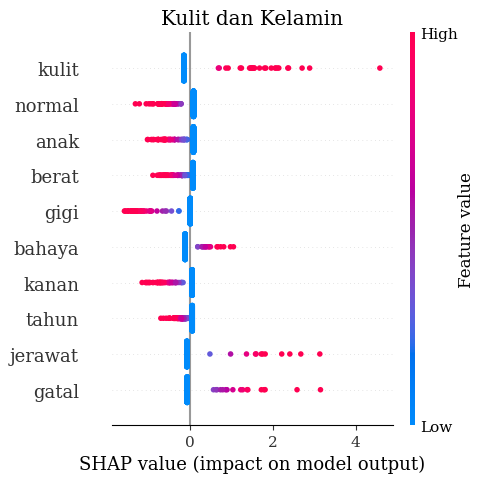

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


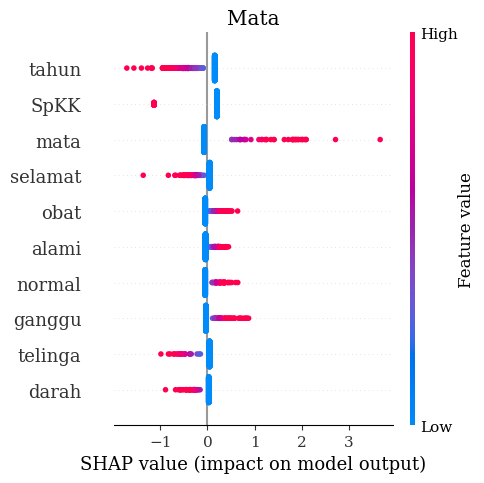

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


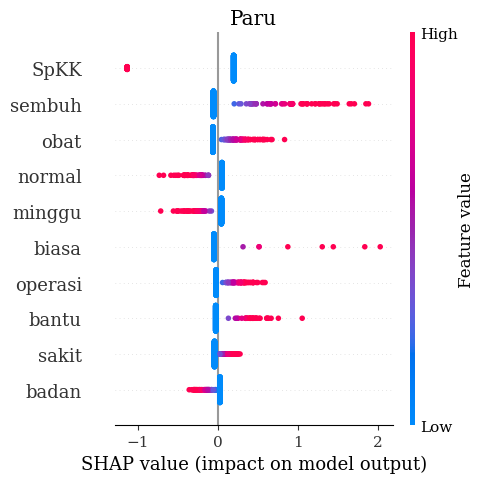

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


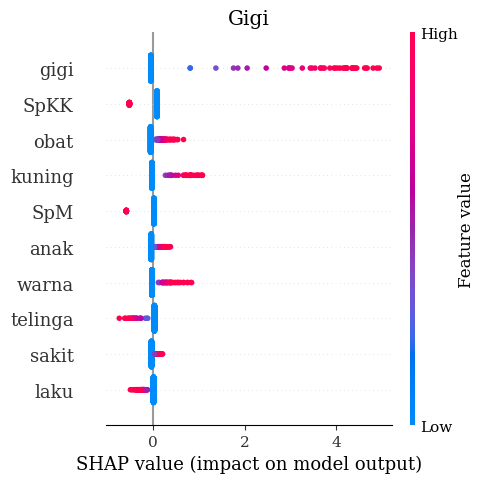

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


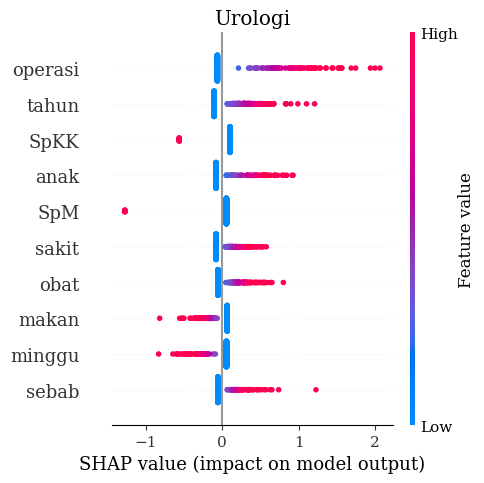

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


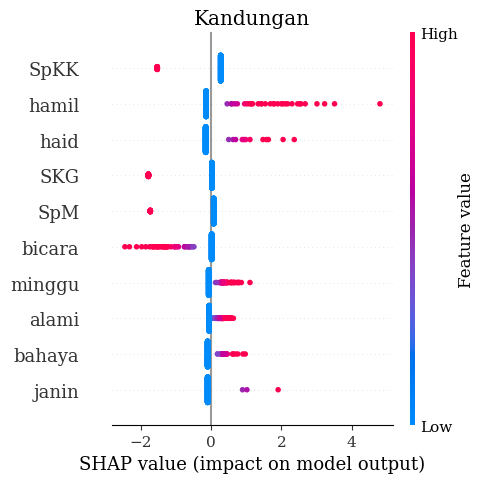

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


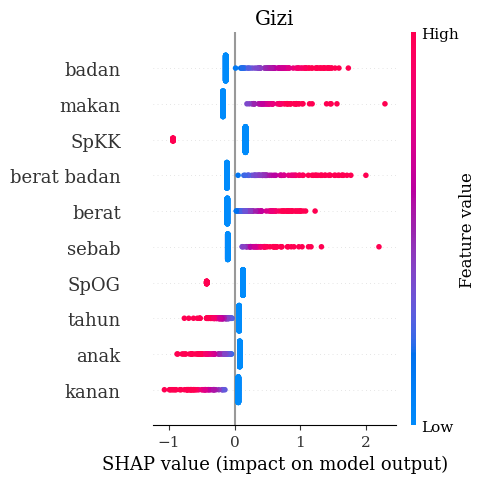

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


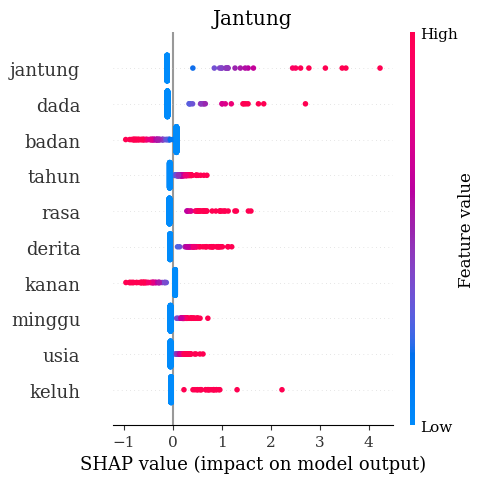

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


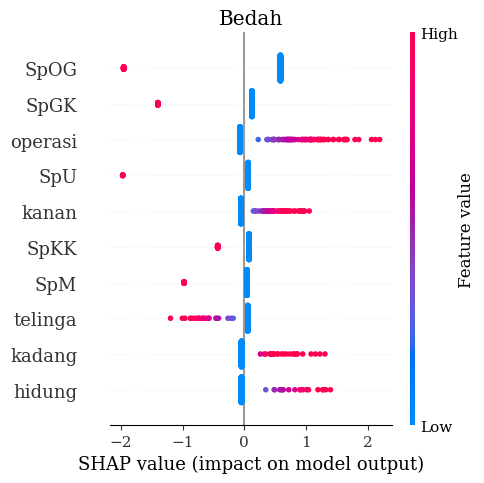

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


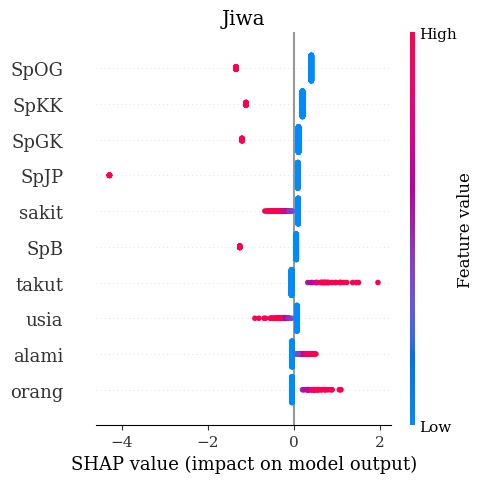

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


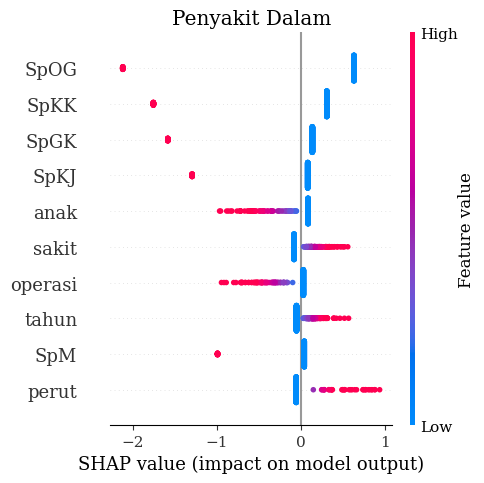

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


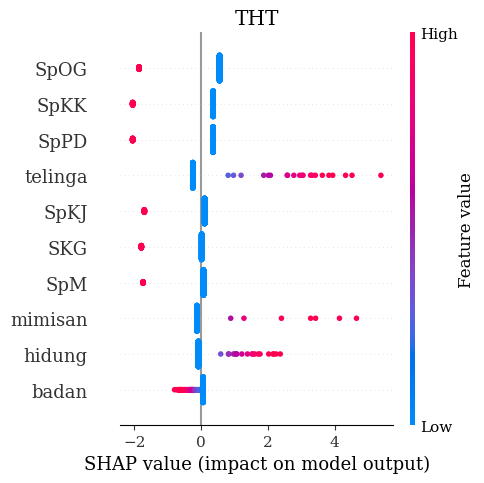

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


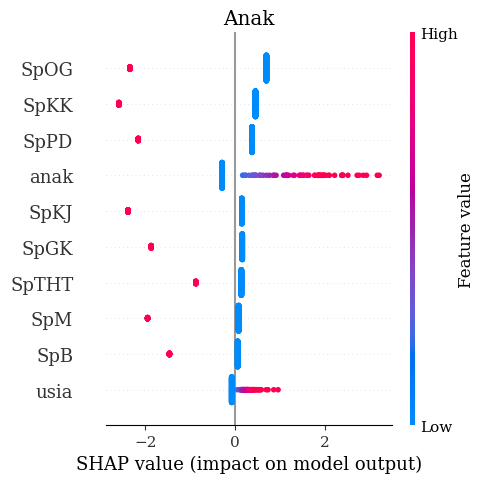

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


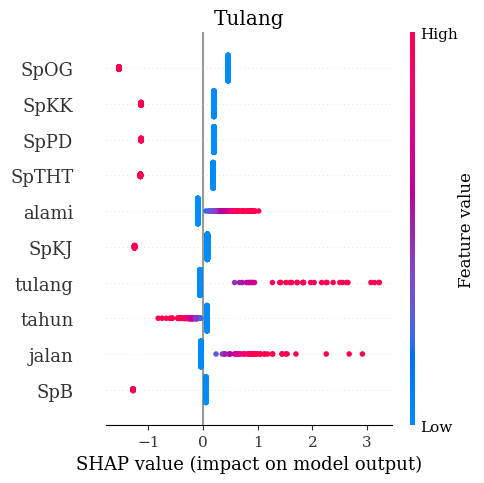

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


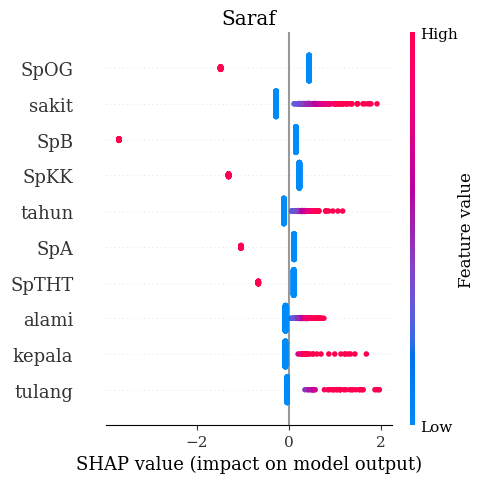

In [ ]:
save_chain_plots(explainers, chain_test, tfidf_chain)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


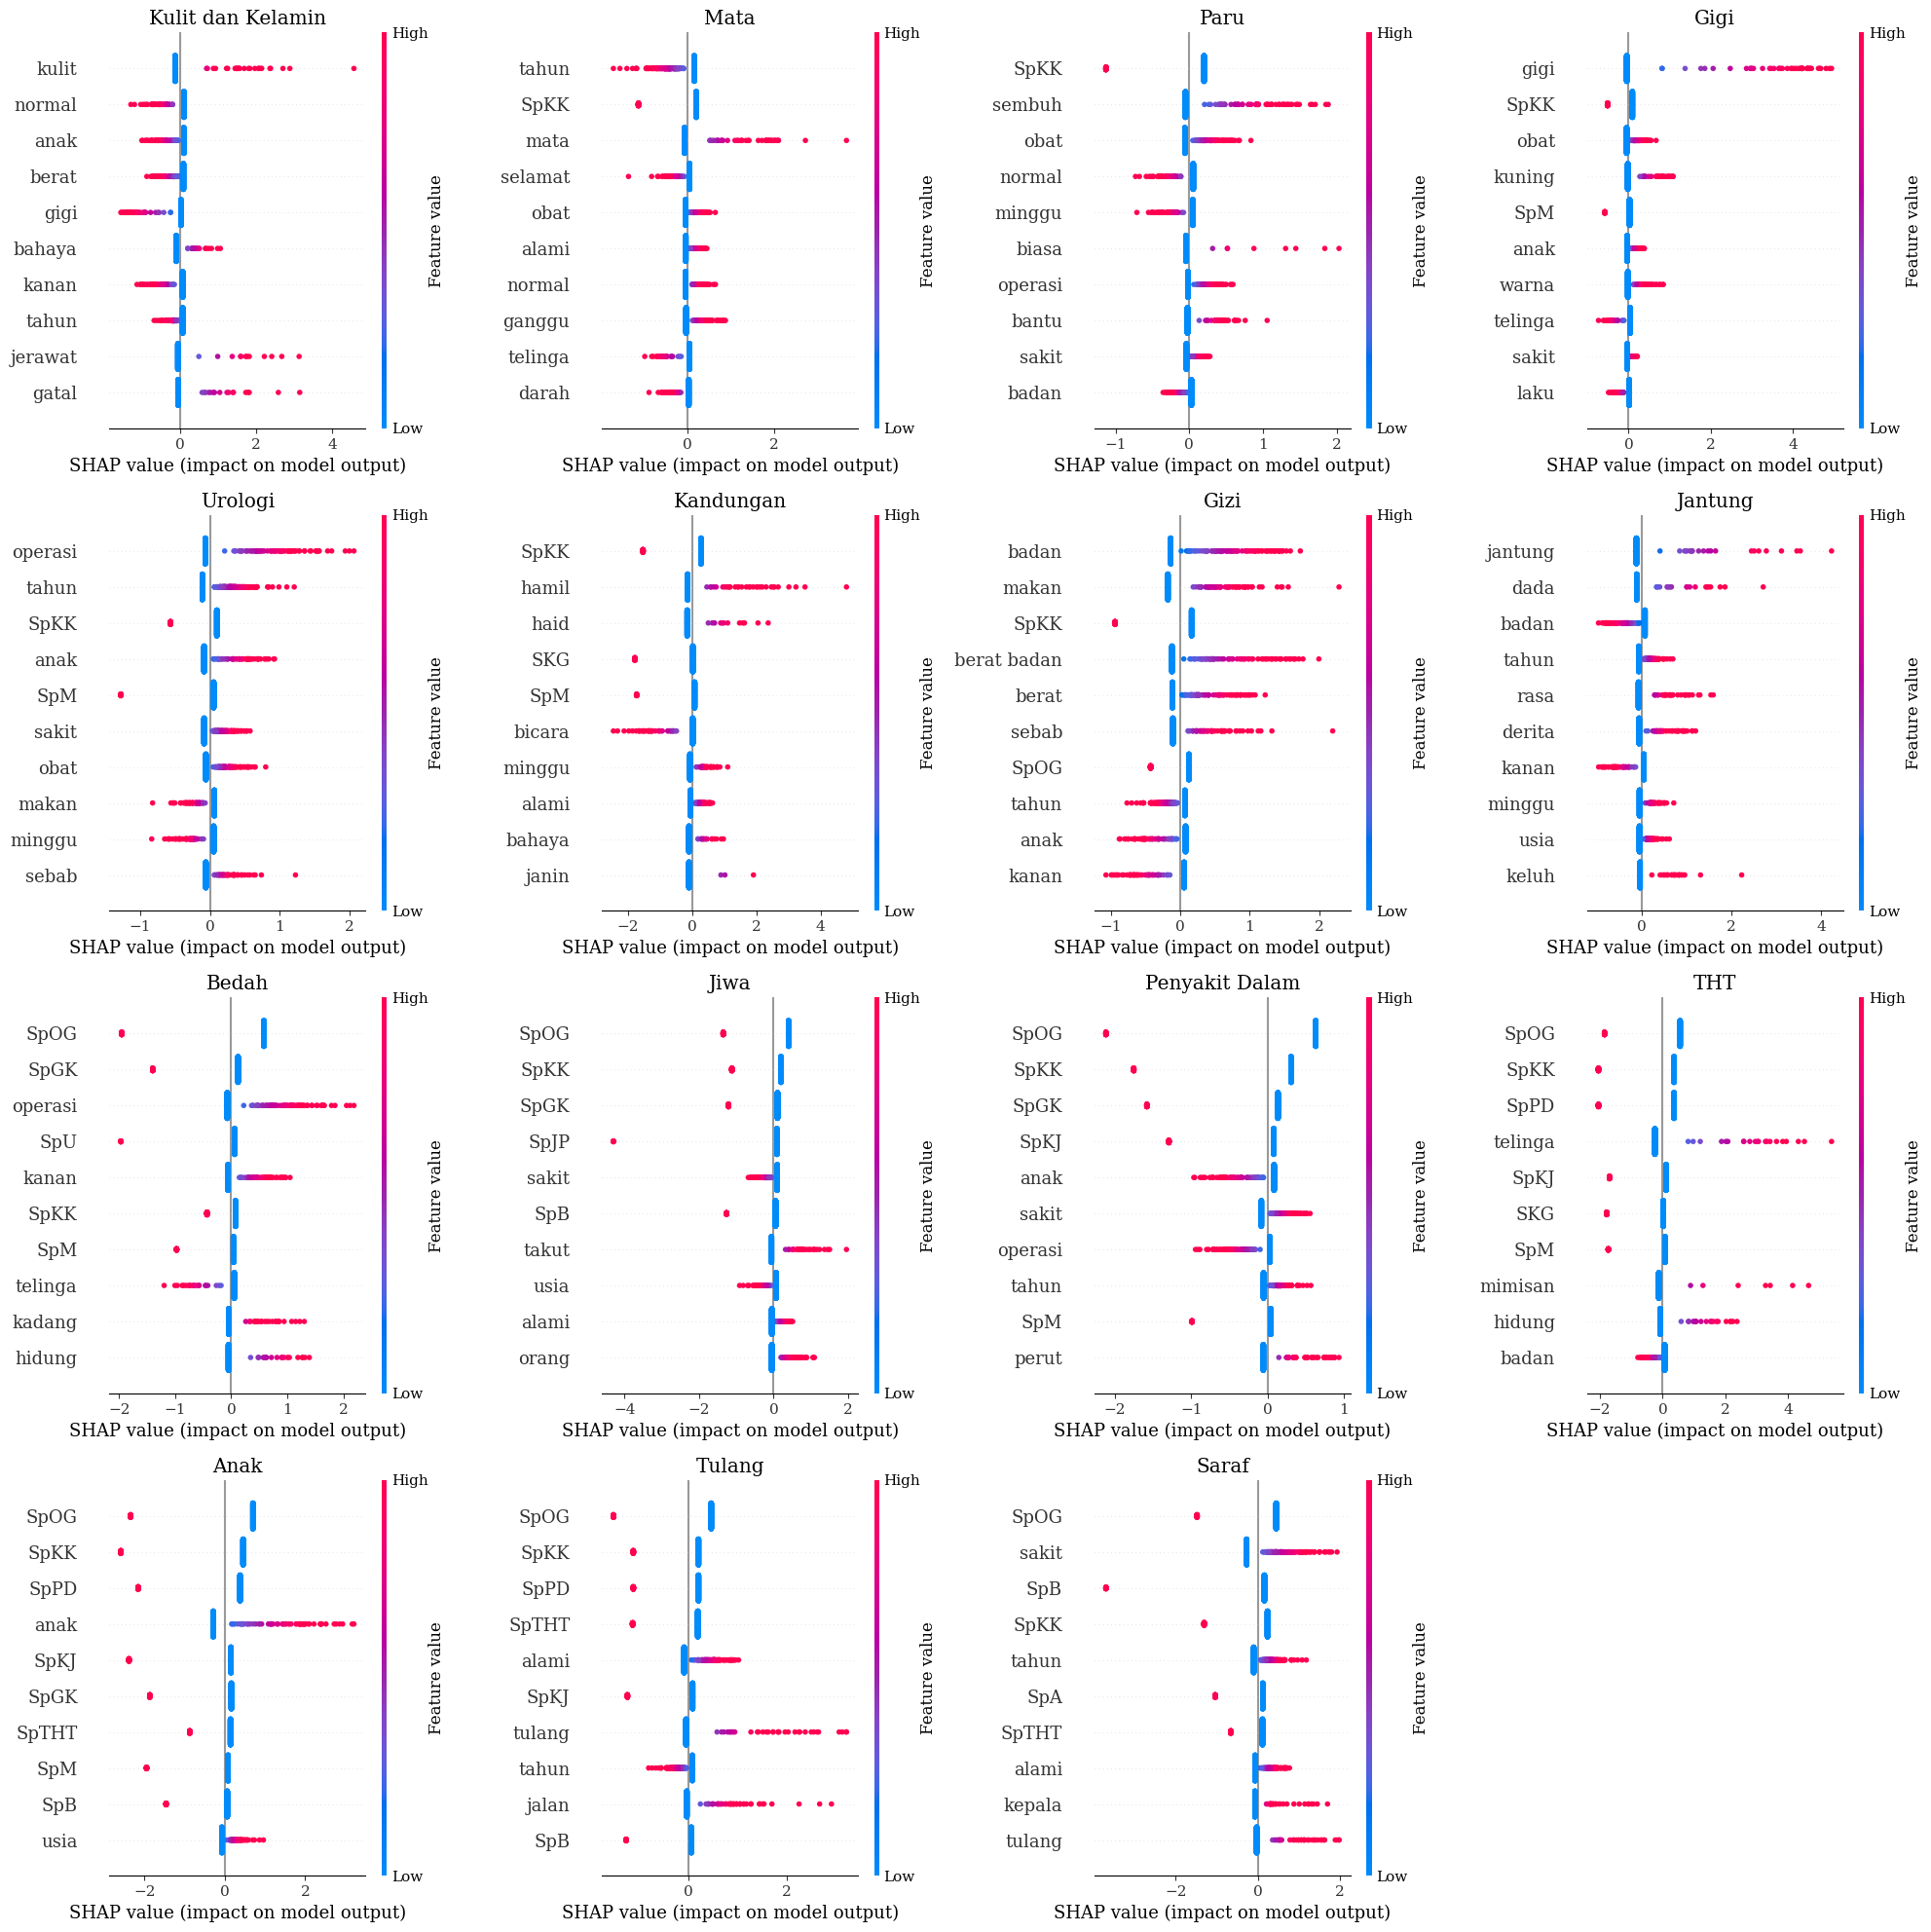

In [ ]:
summary_chain_plots4(explainers, chain_test, tfidf_chain)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


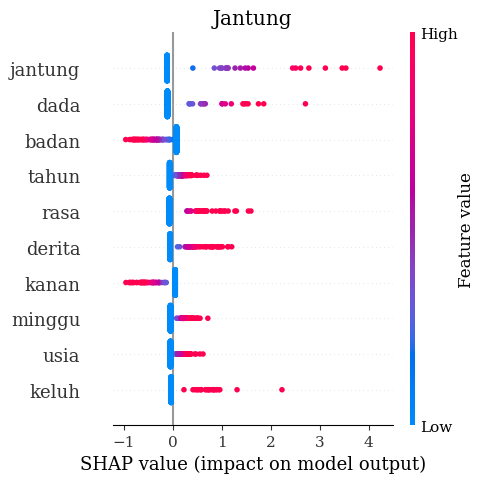

In [ ]:
#@title Jantung
cat = "Jantung" #@param {type:"string"}
plt.figure(figsize = (5, 5))
plt.title(cat)
shap.summary_plot(explainers[cat].shap_values(chain_test[cat]),
                  chain_test[cat],
                  feature_names=tfidf_chain[cat],
                  plot_size=None,
                  max_display = 10,
                  show = False)
plt.tight_layout()
# path = f"Assets/shap-{cat}"
# plt.savefig(f'{path}.png', dpi=300, transparent=True)
# plt.savefig(f'{path}.pdf')
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


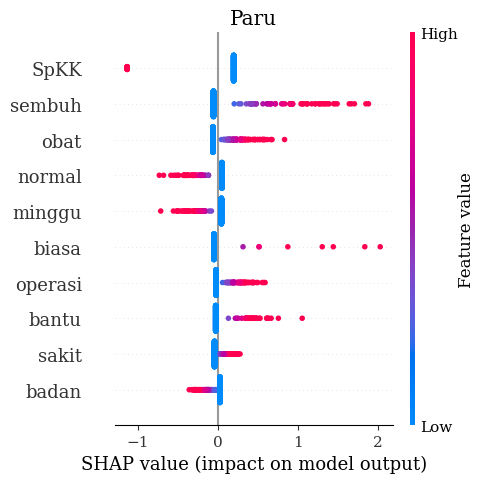

In [ ]:
#@title Paru
cat = "Paru" #@param {type:"string"}
plt.figure(figsize = (5, 5))
plt.title(cat)
shap.summary_plot(explainers[cat].shap_values(chain_test[cat]),
                  chain_test[cat],
                  feature_names=tfidf_chain[cat],
                  plot_size=None,
                  max_display = 10,
                  show = False)
plt.tight_layout()
path = f"Assets/shap-{cat}"
plt.savefig(f'{path}.png', dpi=300, transparent=True)
plt.savefig(f'{path}.pdf')
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


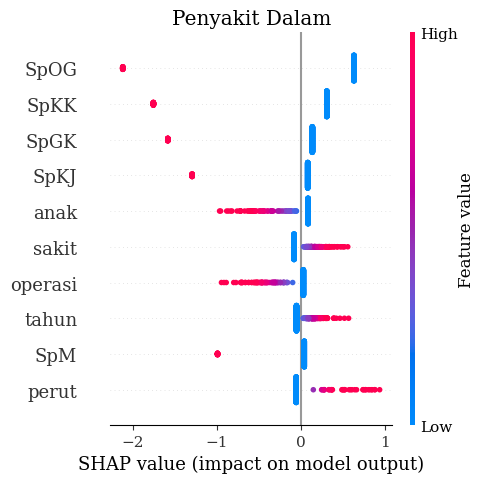

In [ ]:
#@title Penyakit Dalam
cat = "Penyakit Dalam" #@param {type:"string"}
plt.figure(figsize = (5, 5))
plt.title(cat)
shap.summary_plot(explainers[cat].shap_values(chain_test[cat]),
                  chain_test[cat],
                  feature_names=tfidf_chain[cat],
                  plot_size=None,
                  max_display = 10,
                  show = False)
plt.tight_layout()
path = f"Assets/shap-{cat}"
plt.savefig(f'{path}.png', dpi=300, transparent=True)
plt.savefig(f'{path}.pdf')
plt.show()